In [1]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import xgboost
import catboost
from sklearn.model_selection import train_test_split
import zipfile
import os
import gradio

In [2]:
# importar archivos csv# Abrir el archivo comprimido
with zipfile.ZipFile('datasets/teams/battlelog_teams.zip', 'r') as zip_ref:
    # Extraer el archivo CSV
    zip_ref.extractall('datasets/teams/')

crossBattlelog = pd.read_csv('datasets/teams/battlelog_teams.csv', index_col=0)

os.remove('datasets/teams/battlelog_teams.csv')

crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531208 entries, 0 to 531207
Data columns (total 63 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   battleTime                             531208 non-null  object 
 1   playertag                              531208 non-null  object 
 2   event.id                               531208 non-null  int64  
 3   event.mode                             531208 non-null  object 
 4   event.map                              531208 non-null  object 
 5   battle.mode                            531208 non-null  object 
 6   battle.type                            531208 non-null  object 
 7   battle.result                          531208 non-null  object 
 8   battle.duration                        531208 non-null  float64
 9   battle.trophyChange                    393833 non-null  float64
 10  battle.starPlayer.tag                  446999 non-null  

In [3]:
# importar archivos csv
brawlers = pd.read_csv('datasets/brawlers/brawlers_stats.csv', index_col=0)
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers      64 non-null     object 
 3   gadgets         64 non-null     object 
 4   Brawler         64 non-null     object 
 5   Health          64 non-null     float64
 6   Rarity          64 non-null     object 
 7   Class           64 non-null     object 
 8   Movement_Speed  64 non-null     object 
 9   Range           63 non-null     object 
 10  Reload          63 non-null     object 
 11  Speed_Num       64 non-null     int64  
 12  Range_Num       64 non-null     float64
 13  Reload_Num      63 non-null     float64
 14  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(10)
memory usage: 8.0+ KB


In [4]:
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)

In [5]:
brawler_wr_ur = pd.read_csv('datasets/teams/brawler_winrate_userate.csv', index_col=0)

In [6]:
# crear columna playerteam
for i in range(len(crossBattlelog)):
	if any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team1.player1.tag'], crossBattlelog.loc[i, 'battle.team1.player2.tag'], crossBattlelog.loc[i, 'battle.team1.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team1'
	elif any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team2.player1.tag'], crossBattlelog.loc[i, 'battle.team2.player2.tag'], crossBattlelog.loc[i, 'battle.team2.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team2'
	else:
		print("error in team assignation for id " + str(i))

crossBattlelog['player_team'].value_counts()

team1    267222
team2    263986
Name: player_team, dtype: int64

In [7]:
# crear columna winner_team
for i in range(len(crossBattlelog)):
	if crossBattlelog.loc[i, 'battle.result'] == 'draw':
		crossBattlelog.loc[i, 'winner_team'] = 'draw'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	else:
		print("error in winner assignation for id " + str(i))

crossBattlelog['winner_team'].value_counts()

team1    267118
team2    260597
draw       3493
Name: winner_team, dtype: int64

In [8]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['winner_team'] != 'draw'].reset_index(drop=True)

In [9]:
# crear columna winner
def clean_winner(team):

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'
	
	dfw = crossBattlelog[crossBattlelog['player_team'] == team].reset_index(drop = True)

	for i, winner_team in enumerate(dfw['winner_team']):
		if winner_team == 'draw':
			winner = 'd'
		elif winner_team == team:
			winner = 'y'
		else:
			winner = 'n'
		
		dfw.loc[i, 'winner'] = winner

	dfw = dfw.drop('winner_team', axis=1)

	dfw = dfw.rename(columns={
		'battle.' + team + '.player1.brawler.name': 'battle.team1.player1.brawler.name'
		,'battle.' + team + '.player1.brawler.power': 'battle.team1.player1.brawler.power'
		,'battle.' + team + '.player1.brawler.trophies': 'battle.team1.player1.brawler.trophies'
		,'battle.' + team + '.player2.brawler.name': 'battle.team1.player2.brawler.name'
		,'battle.' + team + '.player2.brawler.power': 'battle.team1.player2.brawler.power'
		,'battle.' + team + '.player2.brawler.trophies': 'battle.team1.player2.brawler.trophies'
		,'battle.' + team + '.player3.brawler.name': 'battle.team1.player3.brawler.name'
		,'battle.' + team + '.player3.brawler.power': 'battle.team1.player3.brawler.power'
		,'battle.' + team + '.player3.brawler.trophies': 'battle.team1.player3.brawler.trophies'
		,'battle.' + oteam + '.player1.brawler.name': 'battle.team2.player1.brawler.name'
		,'battle.' + oteam + '.player1.brawler.power': 'battle.team2.player1.brawler.power'
		,'battle.' + oteam + '.player1.brawler.trophies': 'battle.team2.player1.brawler.trophies'
		,'battle.' + oteam + '.player2.brawler.name': 'battle.team2.player2.brawler.name'
		,'battle.' + oteam + '.player2.brawler.power': 'battle.team2.player2.brawler.power'
		,'battle.' + oteam + '.player2.brawler.trophies': 'battle.team2.player2.brawler.trophies'
		,'battle.' + oteam + '.player3.brawler.name': 'battle.team2.player3.brawler.name'
		,'battle.' + oteam + '.player3.brawler.power': 'battle.team2.player3.brawler.power'
		,'battle.' + oteam + '.player3.brawler.trophies': 'battle.team2.player3.brawler.trophies'
	})

	dfw = dfw[[	
		'event.mode'
		,'event.map'
		,'battle.type'
		,'battle.duration'
		,'battle.team1.player1.brawler.name'
		,'battle.team1.player1.brawler.power'
		,'battle.team1.player1.brawler.trophies'
		,'battle.team1.player2.brawler.name'
		,'battle.team1.player2.brawler.power'
		,'battle.team1.player2.brawler.trophies'
		,'battle.team1.player3.brawler.name'
		,'battle.team1.player3.brawler.power'
		,'battle.team1.player3.brawler.trophies'
		,'battle.team2.player1.brawler.name'
		,'battle.team2.player1.brawler.power'
		,'battle.team2.player1.brawler.trophies'
		,'battle.team2.player2.brawler.name'
		,'battle.team2.player2.brawler.power'
		,'battle.team2.player2.brawler.trophies'
		,'battle.team2.player3.brawler.name'
		,'battle.team2.player3.brawler.power'
		,'battle.team2.player3.brawler.trophies'
		,'winner'
	]]
	
	dfl = crossBattlelog[crossBattlelog['player_team'] == team].reset_index(drop = True)

	for i, winner_team in enumerate(dfl['winner_team']):
		if winner_team == 'draw':
			winner = 'd'
		elif winner_team == oteam:
			winner = 'y'
		else:
			winner = 'n'
		
		dfl.loc[i, 'winner'] = winner

	dfl = dfl.drop('winner_team', axis=1)

	dfl = dfl.rename(columns={
		'battle.' + oteam + '.player1.brawler.name': 'battle.team1.player1.brawler.name'
		,'battle.' + oteam + '.player1.brawler.power': 'battle.team1.player1.brawler.power'
		,'battle.' + oteam + '.player1.brawler.trophies': 'battle.team1.player1.brawler.trophies'
		,'battle.' + oteam + '.player2.brawler.name': 'battle.team1.player2.brawler.name'
		,'battle.' + oteam + '.player2.brawler.power': 'battle.team1.player2.brawler.power'
		,'battle.' + oteam + '.player2.brawler.trophies': 'battle.team1.player2.brawler.trophies'
		,'battle.' + oteam + '.player3.brawler.name': 'battle.team1.player3.brawler.name'
		,'battle.' + oteam + '.player3.brawler.power': 'battle.team1.player3.brawler.power'
		,'battle.' + oteam + '.player3.brawler.trophies': 'battle.team1.player3.brawler.trophies'
		,'battle.' + team + '.player1.brawler.name': 'battle.team2.player1.brawler.name'
		,'battle.' + team + '.player1.brawler.power': 'battle.team2.player1.brawler.power'
		,'battle.' + team + '.player1.brawler.trophies': 'battle.team2.player1.brawler.trophies'
		,'battle.' + team + '.player2.brawler.name': 'battle.team2.player2.brawler.name'
		,'battle.' + team + '.player2.brawler.power': 'battle.team2.player2.brawler.power'
		,'battle.' + team + '.player2.brawler.trophies': 'battle.team2.player2.brawler.trophies'
		,'battle.' + team + '.player3.brawler.name': 'battle.team2.player3.brawler.name'
		,'battle.' + team + '.player3.brawler.power': 'battle.team2.player3.brawler.power'
		,'battle.' + team + '.player3.brawler.trophies': 'battle.team2.player3.brawler.trophies'
	})

	dfl = dfl[[	
		'event.mode'
		,'event.map'
		,'battle.type'
		,'battle.duration'
		,'battle.team1.player1.brawler.name'
		,'battle.team1.player1.brawler.power'
		,'battle.team1.player1.brawler.trophies'
		,'battle.team1.player2.brawler.name'
		,'battle.team1.player2.brawler.power'
		,'battle.team1.player2.brawler.trophies'
		,'battle.team1.player3.brawler.name'
		,'battle.team1.player3.brawler.power'
		,'battle.team1.player3.brawler.trophies'
		,'battle.team2.player1.brawler.name'
		,'battle.team2.player1.brawler.power'
		,'battle.team2.player1.brawler.trophies'
		,'battle.team2.player2.brawler.name'
		,'battle.team2.player2.brawler.power'
		,'battle.team2.player2.brawler.trophies'
		,'battle.team2.player3.brawler.name'
		,'battle.team2.player3.brawler.power'
		,'battle.team2.player3.brawler.trophies'
		,'winner'
	]]

	return pd.concat([dfw, dfl], ignore_index=True)

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogProcess = pd.concat([team1, team2], ignore_index=True).reset_index(drop = True)
battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055430 entries, 0 to 1055429
Data columns (total 23 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event.mode                             1055430 non-null  object 
 1   event.map                              1055430 non-null  object 
 2   battle.type                            1055430 non-null  object 
 3   battle.duration                        1055430 non-null  float64
 4   battle.team1.player1.brawler.name      1055430 non-null  object 
 5   battle.team1.player1.brawler.power     1055430 non-null  float64
 6   battle.team1.player1.brawler.trophies  1055430 non-null  float64
 7   battle.team1.player2.brawler.name      1055430 non-null  object 
 8   battle.team1.player2.brawler.power     1055430 non-null  float64
 9   battle.team1.player2.brawler.trophies  1055430 non-null  float64
 10  battle.team1.player3.brawler.name      105

In [10]:
battlelogProcess['winner'].value_counts()

y    527715
n    527715
Name: winner, dtype: int64

In [11]:
# merge brawler stats
battlelogFinal = battlelogProcess

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogFinal = add_brawlers(battlelogFinal, 'battle.team1.player1.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team1.player2.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team1.player3.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team2.player1.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team2.player2.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team2.player3.brawler.')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055430 entries, 0 to 1055429
Data columns (total 83 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   event.mode                                   1055430 non-null  object 
 1   event.map                                    1055430 non-null  object 
 2   battle.type                                  1055430 non-null  object 
 3   battle.duration                              1055430 non-null  float64
 4   battle.team1.player1.brawler.name            1055430 non-null  object 
 5   battle.team1.player1.brawler.power           1055430 non-null  float64
 6   battle.team1.player1.brawler.trophies        1055430 non-null  float64
 7   battle.team1.player2.brawler.name            1055430 non-null  object 
 8   battle.team1.player2.brawler.power           1055430 non-null  float64
 9   battle.team1.player2.brawler.trophies        1

In [12]:
# merge map data
battlelogFinal = battlelogFinal.merge(barrierList, how='inner', on='event.map')
battlelogFinal = battlelogFinal.merge(bushList, how='inner', on='event.map')
battlelogFinal = battlelogFinal.merge(waterList, how='left', on='event.map')
battlelogFinal['waterProp'] = battlelogFinal['waterProp'].fillna(0)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055430 entries, 0 to 1055429
Data columns (total 88 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   event.mode                                   1055430 non-null  object 
 1   event.map                                    1055430 non-null  object 
 2   battle.type                                  1055430 non-null  object 
 3   battle.duration                              1055430 non-null  float64
 4   battle.team1.player1.brawler.name            1055430 non-null  object 
 5   battle.team1.player1.brawler.power           1055430 non-null  float64
 6   battle.team1.player1.brawler.trophies        1055430 non-null  float64
 7   battle.team1.player2.brawler.name            1055430 non-null  object 
 8   battle.team1.player2.brawler.power           1055430 non-null  float64
 9   battle.team1.player2.brawler.trophies        1

In [13]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event.mode', 'event.map', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event.mode', 'event.map']
		,right_on=[prefix + 'brawlername', prefix + 'event.mode', prefix + 'event.map']
		,how='left'
		,suffixes=('','_w'))
	return df

battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team1.player1.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team1.player2.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team1.player3.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team2.player1.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team2.player2.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team2.player3.brawler.')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055430 entries, 0 to 1055429
Columns: 124 entries, event.mode to battle.team2.player3.brawler.percentile_quadrant
dtypes: float64(46), int64(8), object(70)
memory usage: 1006.5+ MB


In [14]:
# crear columna battle brawlers
# def create_list_name(row, column):
#     return [str(row['battle.player1.brawler.' + column]), str(row['battle.player2.brawler.' + column]), str(row['battle.player3.brawler.' + column])]

# battlelogFinal['battle.brawlers'] = battlelogFinal.apply(lambda row: create_list_name(row, 'name'), axis=1)
# battlelogFinal['battle.brawlers'] = [str(sorted(roles)) for roles in battlelogFinal['battle.brawlers']]

# battlelogFinal['battle.brawlers']

In [15]:
plt.style.use('ggplot')

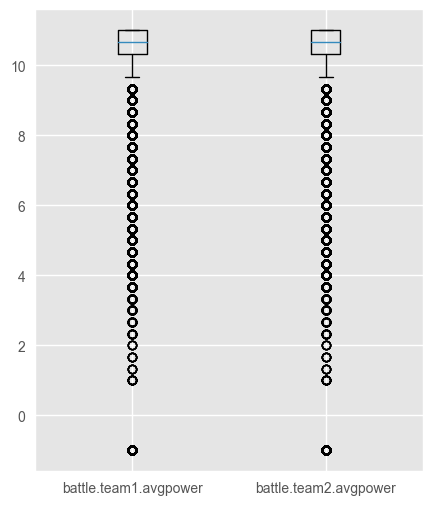

In [16]:
# crear columna avg power
def create_avg(row, team, column):
    return (row['battle.' + team + '.player1.brawler.'+ column] + row['battle.' + team + '.player2.brawler.'+ column] + row['battle.' + team + '.player3.brawler.'+ column]) / 3

def create_boxplots(df, col1, col2):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 6)
    ax.boxplot([df[col1], df[col2]])
    ax.set_xticklabels([col1, col2])
    plt.show()

battlelogFinal['battle.team1.avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team1.avgpower'].isna() == False]
battlelogFinal['battle.team2.avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team2.avgpower'].isna() == False]

create_boxplots(battlelogFinal, 'battle.team1.avgpower', 'battle.team2.avgpower')

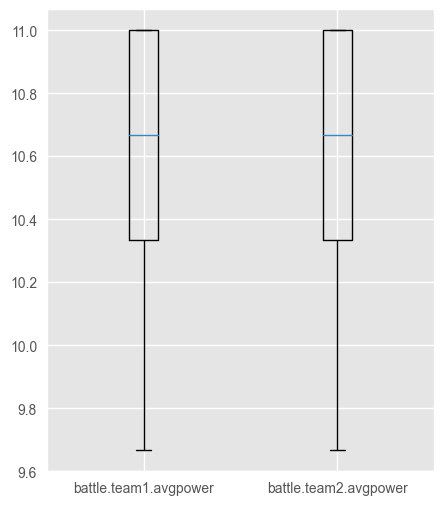

In [17]:
# subset avg power
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avgpower'] > 9.5) & (battlelogFinal['battle.team2.avgpower'] > 9.5)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avgpower', 'battle.team2.avgpower')

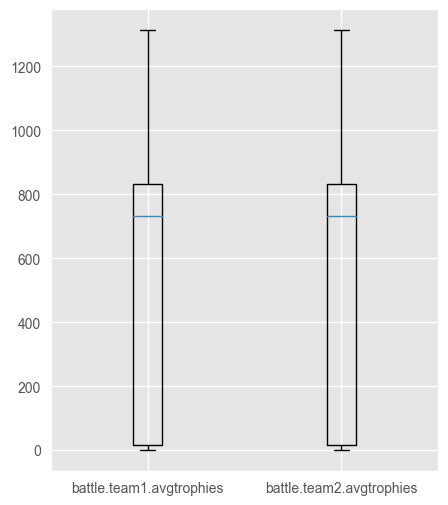

In [18]:
# crear columna avg trophies
battlelogFinal['battle.team1.avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'trophies'), axis=1)
battlelogFinal['battle.team2.avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'trophies'), axis=1)

create_boxplots(battlelogFinal, 'battle.team1.avgtrophies', 'battle.team2.avgtrophies')

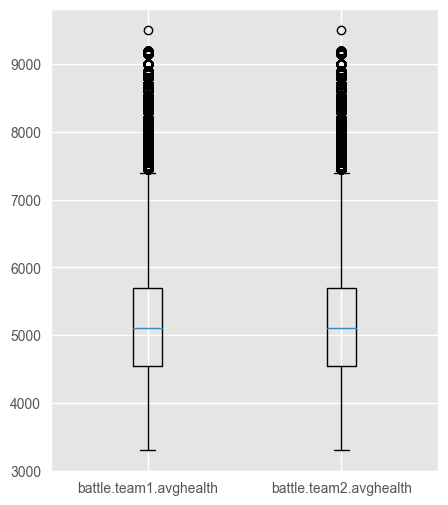

In [19]:
# crear columna avg health
battlelogFinal['battle.team1.avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'Health'), axis=1).reset_index(drop=True)
battlelogFinal['battle.team2.avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'Health'), axis=1).reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avghealth', 'battle.team2.avghealth')

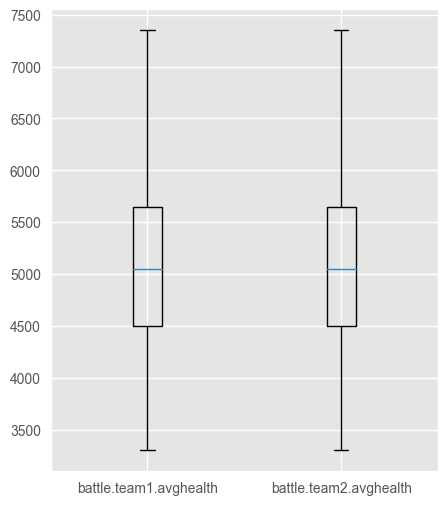

In [20]:
# subset avg health
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avghealth'] < 7400) & (battlelogFinal['battle.team2.avghealth'] < 7400)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avghealth', 'battle.team2.avghealth')

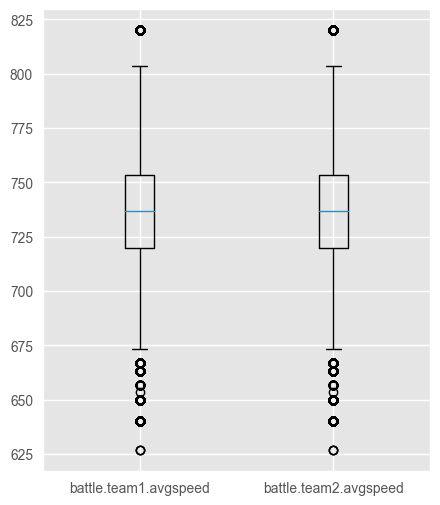

In [21]:
# crear columna avg speed
battlelogFinal['battle.team1.avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'Speed_Num'), axis=1)
battlelogFinal['battle.team2.avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'Speed_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle.team1.avgspeed', 'battle.team2.avgspeed')

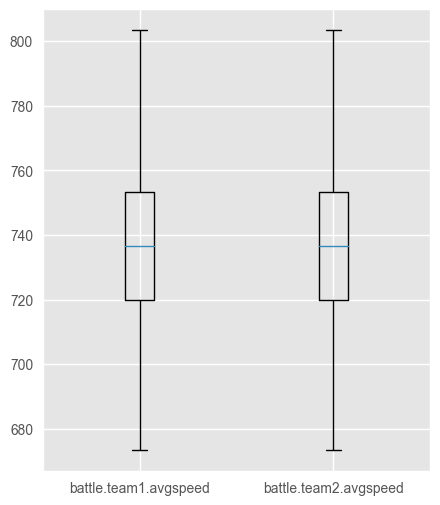

In [22]:
# subset avg speed
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avgspeed'] >= 670) & (battlelogFinal['battle.team1.avgspeed'] <= 810) & (battlelogFinal['battle.team2.avgspeed'] >= 670) & (battlelogFinal['battle.team2.avgspeed'] <= 810)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avgspeed', 'battle.team2.avgspeed')

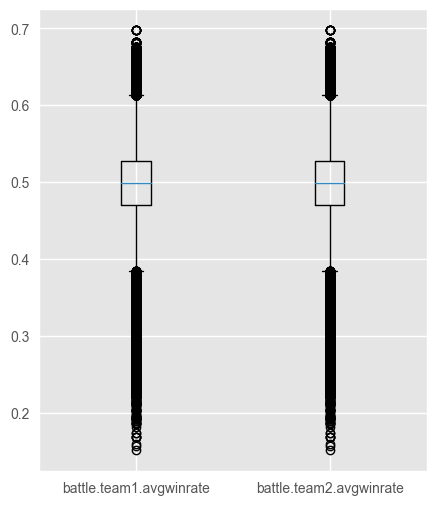

In [23]:
# crear columna avg winrate
battlelogFinal['battle.team1.avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team1.avgwinrate'].isna() == False]
battlelogFinal['battle.team2.avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team2.avgwinrate'].isna() == False]

create_boxplots(battlelogFinal, 'battle.team1.avgwinrate', 'battle.team2.avgwinrate')

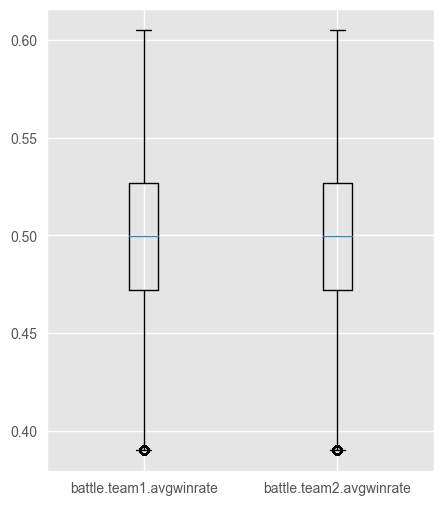

In [24]:
# subset avg winrate
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avgwinrate'] >= 0.39) & (battlelogFinal['battle.team1.avgwinrate'] <= 0.605) & (battlelogFinal['battle.team2.avgwinrate'] >= 0.39) & (battlelogFinal['battle.team2.avgwinrate'] <= 0.605)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avgwinrate', 'battle.team2.avgwinrate')

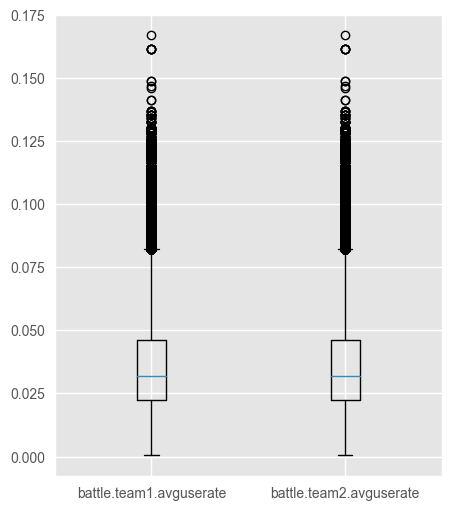

In [25]:
# crear columna avg userate
battlelogFinal['battle.team1.avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'userate'), axis=1)
battlelogFinal['battle.team2.avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'userate'), axis=1)

create_boxplots(battlelogFinal, 'battle.team1.avguserate', 'battle.team2.avguserate')

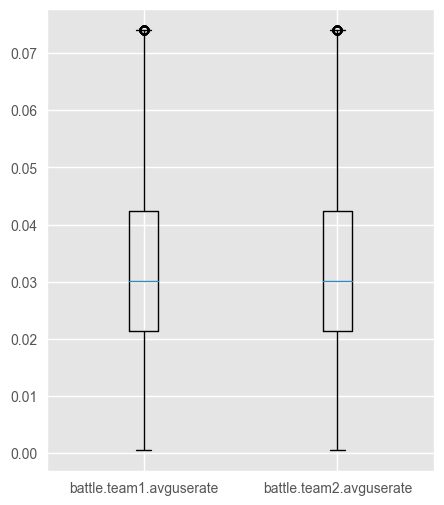

In [26]:
# subset avg userate
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avguserate'] <= 0.074) & (battlelogFinal['battle.team2.avguserate'] <= 0.074)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avguserate', 'battle.team2.avguserate')

In [27]:
battlelogFinal.shape

(745614, 136)

In [28]:
battlelog = battlelogFinal[[                             
'winner'
,'barriers'
,'barriers_center'
,'bushes'
,'bushes_center'
,'waterProp'
,'battle.duration'
,'battle.team1.avgpower'
,'battle.team1.avgtrophies'
,'battle.team1.avghealth'
,'battle.team1.avgspeed'
,'battle.team1.avgwinrate'
,'battle.team1.avguserate'
,'battle.team2.avgpower'
,'battle.team2.avgtrophies'
,'battle.team2.avghealth'
,'battle.team2.avgspeed'
,'battle.team2.avgwinrate'
,'battle.team2.avguserate'
]]

battlelog.head()

,winner,barriers,barriers_center,bushes,bushes_center,waterProp,battle.duration,battle.team1.avgpower,battle.team1.avgtrophies,battle.team1.avghealth,battle.team1.avgspeed,battle.team1.avgwinrate,battle.team1.avguserate,battle.team2.avgpower,battle.team2.avgtrophies,battle.team2.avghealth,battle.team2.avgspeed,battle.team2.avgwinrate,battle.team2.avguserate
0,y,71,26,78,22,0.0,150.0,10.333333,768.333333,4600.0,753.333333,0.474909,0.033764,10.333333,772.000000,5300.0,786.666667,0.429632,0.048705
1,y,71,26,78,22,0.0,93.0,11.000000,1109.333333,5350.0,736.666667,0.511228,0.017964,10.666667,799.666667,4400.0,753.333333,0.470646,0.014540
2,y,71,26,78,22,0.0,135.0,11.000000,1105.333333,5350.0,736.666667,0.511228,0.017964,11.000000,868.000000,5550.0,736.666667,0.521827,0.021338
3,y,71,26,78,22,0.0,44.0,11.000000,1102.666667,6850.0,736.666667,0.530372,0.017456,10.333333,871.666667,5900.0,770.000000,0.467683,0.022188
4,y,71,26,78,22,0.0,31.0,11.000000,1049.333333,5900.0,770.000000,0.503988,0.015472,11.000000,863.333333,4000.0,696.666667,0.488466,0.032563


In [29]:
# generar set de testing y training
seed=14683

train, test = train_test_split(battlelog, test_size = 0.5, random_state=seed, stratify=battlelog['winner'])

train.shape

(372807, 19)

In [35]:
# setup model
session_1 = setup(
	data = train,
	target = 'winner',
	fix_imbalance = True,
    feature_selection= True,
	remove_outliers=True,
	log_experiment = False,
    use_gpu=False)

,Description,Value
0,session_id,3174
1,Target,winner
2,Target Type,Binary
3,Label Encoded,"n: 0, y: 1"
4,Original Data,"(372807, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [37]:
#comparación de modelos
models = compare_models(include=['rf','gbc','lightgbm','ada','catboost','xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6424,0.7116,0.6415,0.6421,0.6418,0.2848,0.2848,41.9880
lightgbm,Light Gradient Boosting Machine,0.6408,0.7086,0.6411,0.6401,0.6406,0.2815,0.2815,5.7970
xgboost,Extreme Gradient Boosting,0.6388,0.7065,0.6405,0.6378,0.6391,0.2776,0.2776,31.1700
rf,Random Forest Classifier,0.6383,0.6993,0.6302,0.6400,0.6351,0.2766,0.2766,40.8010
gbc,Gradient Boosting Classifier,0.6357,0.7014,0.6372,0.6348,0.6360,0.2714,0.2714,39.5460
ada,Ada Boost Classifier,0.6268,0.6885,0.6243,0.6269,0.6256,0.2536,0.2537,11.4190


In [38]:
# creando modelos para el estimador escogido
model = create_model(models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6480,0.7177,0.6474,0.6477,0.6475,0.2960,0.2960
1,0.6398,0.7090,0.6447,0.6379,0.6413,0.2796,0.2796
2,0.6413,0.7126,0.6400,0.6411,0.6406,0.2826,0.2826
3,0.6367,0.7041,0.6340,0.6369,0.6354,0.2734,0.2734
4,0.6375,0.7057,0.6358,0.6374,0.6366,0.2750,0.2750
5,0.6469,0.7164,0.6531,0.6446,0.6488,0.2938,0.2938
6,0.6434,0.7131,0.6404,0.6437,0.6421,0.2868,0.2868
7,0.6410,0.7100,0.6367,0.6417,0.6392,0.2820,0.2820
8,0.6457,0.7149,0.6410,0.6465,0.6437,0.2913,0.2914


In [ ]:
#try model blender

# example:
# train a few models
# lr = create_model('lr')
# dt = create_model('dt')
# knn = create_model('knn')

# blend models
# blender = blend_models([lr, dt, knn])
# blender_tuned = tune_model(blender, optimize = 'F1')

In [42]:
# tunear el modelo
model_tuned = tune_model(model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6434,0.7145,0.6461,0.6422,0.6441,0.2869,0.2869
1,0.6397,0.7051,0.6455,0.6376,0.6415,0.2794,0.2794
2,0.6416,0.7110,0.6424,0.6408,0.6416,0.2832,0.2832
3,0.6345,0.7007,0.6333,0.6343,0.6338,0.2690,0.2690
4,0.6364,0.7036,0.6357,0.6360,0.6359,0.2727,0.2727
5,0.6430,0.7122,0.6471,0.6413,0.6442,0.2860,0.2860
6,0.6441,0.7099,0.6434,0.6438,0.6436,0.2883,0.2883
7,0.6385,0.7075,0.6350,0.6389,0.6369,0.2769,0.2769
8,0.6431,0.7130,0.6403,0.6433,0.6418,0.2861,0.2861


In [ ]:
# compare hyperparameters
print(model)

print(model_tuned)

In [ ]:
# interpret model
interpret_model(model_tuned)

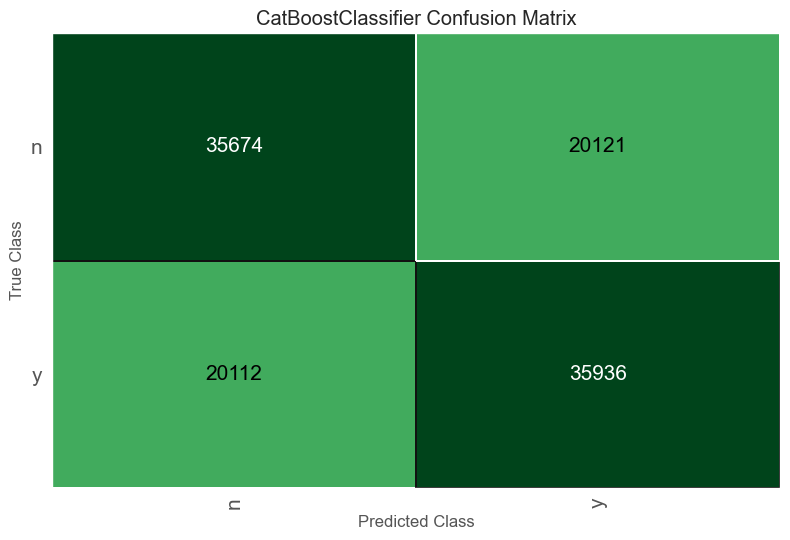

In [44]:
plot_model(model_tuned, plot='confusion_matrix')

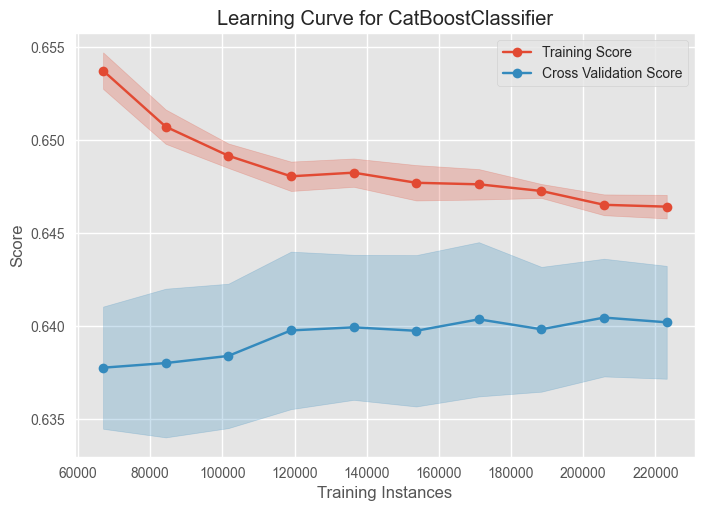

In [45]:
plot_model(model_tuned, plot='learning')

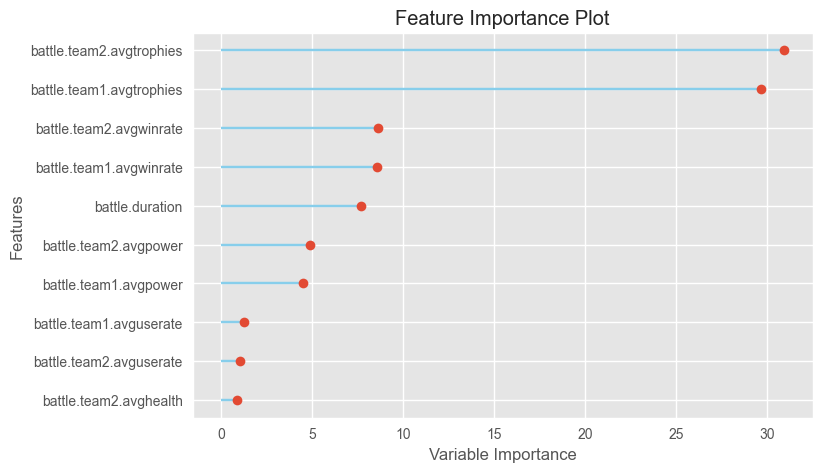

In [46]:
plot_model(model_tuned, plot='feature')

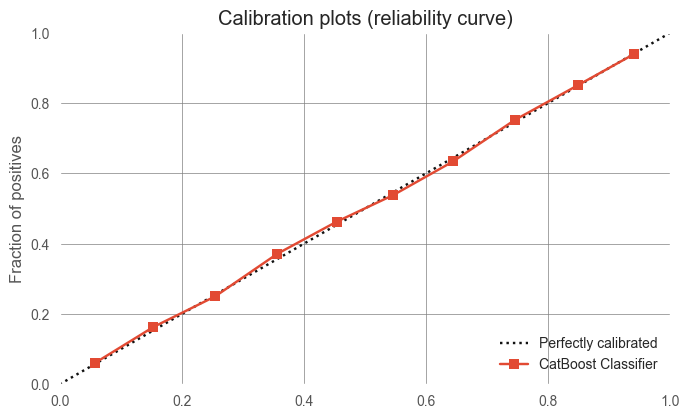

In [47]:
plot_model(model_tuned, plot='calibration')

In [49]:
#finalizar modelo
model_finalized = finalize_model(model_tuned)
predictions = predict_model(model_finalized, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0,0.7107,0,0,0,0,0


In [58]:
create_app(model_finalized)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [51]:
save_model(model_finalized, 'models/catboost_try1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='winner',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('feature_select',
                  Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                     n_jobs=-1,
                                                     random_state=3174,
                    

In [56]:
predictions.to_csv('datasets/predictions/predictions_lc.csv')